In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from stellargraph import StellarGraph
from stellargraph.data import TemporalRandomWalk
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
%matplotlib inline

2024-05-02 00:14:05.377325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
embedding_size = 128
def positive_and_negative_links(g, edges):
    pos = list(edges[["source", "target"]].itertuples(index=False))
    neg,pos = sample_negative_examples(g, pos)
    return pos, neg


def sample_negative_examples(g, positive_examples):
    positive_set = set(positive_examples)
    def valid_neg_edge(src, tgt):
        return (
            # no self-loops
            src != tgt
            and
            # neither direction of the edge should be a positive one
            (src, tgt) not in positive_set
            and (tgt, src) not in positive_set
        )

    possible_neg_edges = [
        (src, tgt) for src in g.nodes() for tgt in g.nodes() if valid_neg_edge(src, tgt)
    ]
    return random.sample(possible_neg_edges, k=len(positive_set)),positive_set
unseen_node_embedding = np.zeros(embedding_size)
def temporal_embedding(u):
    try:
        return temporal_model.wv[u]
    except KeyError:
        return unseen_node_embedding


def static_embedding(u):
    return static_model.wv[u]
def plot_tsne(title, x, y=None):
    tsne = TSNE(n_components=2)
    x_t = tsne.fit_transform(x)

    plt.figure(figsize=(7, 7))
    plt.title(title)
    alpha = 0.7 if y is None else 0.5

    scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)
    if y is not None:
        plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
def operator_l2(u, v):
    return (u - v) ** 2

def link_examples_to_features(link_examples, transform_node):
    op_func = (
        operator_func[binary_operator]
        if isinstance(binary_operator, str)
        else binary_operator
    )
    return [
        op_func(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

def labelled_links(positive_examples, negative_examples):
    return (
        positive_examples + negative_examples,
        np.repeat([1, 0], [len(positive_examples), len(negative_examples)]),
    )

In [3]:
def evaluate_accuracy(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    predicted = predicted[:, positive_column]
    t = []
    for i in predicted:
        if i>0.5:
            t.append(1)
        else:
            t.append(0)
    acc = accuracy_score(link_labels, t)
    f1 = f1_score(link_labels, t)
    print(f"\t\t\tAccuracy: {acc}")
    print(f"\t\t\tF1 score: {f1}")
    return acc,f1

In [4]:
df = pd.read_csv("indego2023q1.csv")
for i in [2,3,4]:
    tempdf = pd.read_csv(f"indego2023q{i}.csv")
    df = pd.concat([df,tempdf], ignore_index=True)
del tempdf
df.head()

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8531/3147249884.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tempdf = pd.read_csv(f"indego2023q{i}.csv")
/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8531/3147249884.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tempdf = pd.read_csv(f"indego2023q{i}.csv")
/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_8531/3147249884.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tempdf = pd.read_csv(f"indego2023q{i}.csv")


,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,579507686,70,1/1/2023 0:00,1/1/2023 1:10,3063,39.946331,-75.169800,3063,39.946331,-75.169800,22584,365,Round Trip,Indego365,electric
1,579499091,17,1/1/2023 0:05,1/1/2023 0:22,3190,39.948921,-75.169907,3207,39.954411,-75.192001,5281,30,One Way,Indego30,standard
2,579499089,11,1/1/2023 0:06,1/1/2023 0:17,3182,39.950809,-75.169533,3102,39.967590,-75.179520,22366,30,One Way,Indego30,electric
3,579499087,1,1/1/2023 0:08,1/1/2023 0:09,3026,39.941818,-75.145500,3026,39.941818,-75.145500,17780,30,Round Trip,Indego30,electric
4,579499085,27,1/1/2023 0:09,1/1/2023 0:36,3046,39.950119,-75.144722,3112,39.953732,-75.218246,16897,30,One Way,Indego30,electric


In [5]:
df.shape

(1084547, 15)

In [6]:
df = df[['start_time','start_station','end_station']][df['trip_route_category']== 'One Way']
df = df.reset_index(drop=True)
df.head()

,start_time,start_station,end_station
0,1/1/2023 0:05,3190,3207
1,1/1/2023 0:06,3182,3102
2,1/1/2023 0:09,3046,3112
3,1/1/2023 0:10,3026,3041
4,1/1/2023 0:13,3046,3295


In [30]:
df.head(50)

,source,target,time
0,3190,3207,300.0
1,3182,3102,360.0
2,3046,3112,540.0
3,3026,3041,600.0
4,3046,3295,780.0
5,3070,3205,960.0
6,3164,3000,1200.0
7,3154,3028,1380.0
8,3182,3064,1380.0
9,3182,3064,1440.0


In [7]:
import datetime
df['start_time']= pd.to_datetime(df['start_time'])
df['start_time'] = [(i - datetime.datetime(2023, 1, 1)).total_seconds() for i in df['start_time']]

In [8]:
df = df.sort_values(by=['start_time']).reset_index(drop=True)
df = df[["start_station","end_station","start_time"]]
df = df.rename(columns={"start_station": "source", "end_station": "target","start_time":"time"})

In [31]:
len(df)

1008622

In [9]:
# subset of edges to split
train_subset = 0.25
test_subset = 0.25

# number of edges to be kept in the graph
num_edges_graph = int(len(df) * (1 - train_subset))

# keep older edges in graph, and predict more recent edges
edges_graph = df[:num_edges_graph]
edges_other = df[num_edges_graph:]

# split recent edges further to train and test sets
edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)

print(
    f"Number of edges in graph: {len(edges_graph)}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in graph: 756466
Number of edges in training set: 189117
Number of edges in test set: 63039


In [10]:
graph = StellarGraph(
    nodes=pd.DataFrame(index=df['source'].unique()),
    edges=edges_graph,
    edge_weight_column="time",
)

In [11]:
pos, neg = positive_and_negative_links(graph, edges_train)
pos_test, neg_test = positive_and_negative_links(graph, edges_test)

In [12]:
print(
    f"{graph.info()}\n"
    f"Training examples: {len(pos)} positive links, {len(neg)} negative links\n"
    f"Test examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
)

StellarGraph: Undirected multigraph
 Nodes: 255, Edges: 756466

 Node types:
  default: [255]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [756466]
        Weights: range=[300, 2.37047e+07], mean=1.36904e+07, std=6.44325e+06
        Features: none
Training examples: 25791 positive links, 25791 negative links
Test examples: 17516 positive links, 17516 negative links


In [13]:
num_walks_per_node = 10
walk_length = 80
context_window_size = 10
num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

In [14]:
temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 2568


In [15]:
static_rw = BiasedRandomWalk(graph)
static_walks = static_rw.run(
    nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
)

print("Number of static random walks: {}".format(len(static_walks)))

Number of static random walks: 2550


In [16]:
embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)
static_model = Word2Vec(
    static_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    #iter=1,
)

/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7688/2972831589.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)
/var/folders/g1/qzd6y3416_75xtvpfnhvgccm0000gn/T/ipykernel_7688/2972831589.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)


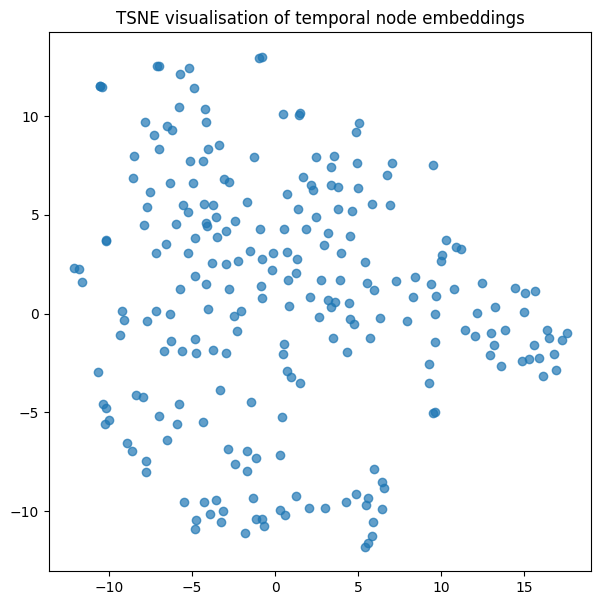

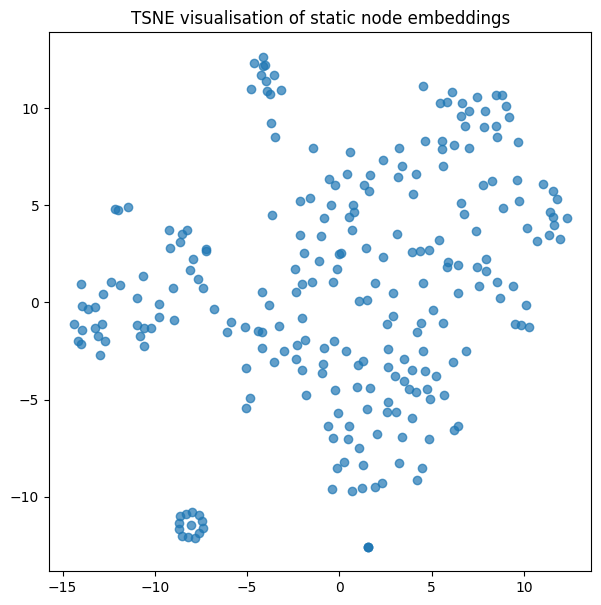

In [17]:
temporal_node_embeddings = temporal_model.wv.vectors
static_node_embeddings = static_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)
plot_tsne("TSNE visualisation of static node embeddings", static_node_embeddings)

In [18]:
binary_operator = operator_l2

In [19]:
link_examples, link_labels = labelled_links(list(pos), neg)
link_examples_test, link_labels_test = labelled_links(list(pos_test), neg_test)

# Logistic Regression

In [25]:
temporal_clf = link_prediction_classifier()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

Score (ROC AUC): 0.85
Accuracy: 0.7653852734842868
F1 score: 0.7850779800935238


In [26]:
static_clf = link_prediction_classifier()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")

Score (ROC AUC): 0.84


In [27]:
#static
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Accuracy: 0.620230422631609
F1 score: 0.6889060200434509


# Decision Tree

In [9]:
from sklearn import tree
def link_prediction_classifier_DT():
    dt_clf = tree.DecisionTreeClassifier()
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", dt_clf)])

In [29]:
temporal_clf = link_prediction_classifier_DT()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(
    temporal_clf, temporal_link_features_test, link_labels_test
)

Score (ROC AUC): 0.84
Accuracy: 0.8249016140991273
F1 score: 0.8379348572031885


In [30]:
static_clf = link_prediction_classifier_DT()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

Score (ROC AUC): 0.84
Accuracy: 0.5507899389722238
F1 score: 0.5782597054886213


# SVC

In [20]:
from sklearn.svm import SVC

## Linear SVC

In [21]:
def link_prediction_classifier_SVC(kernel_m='linear'):
    svm_clf = SVC(kernel=kernel_m, C=1e9, gamma=1e-07, probability=True)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", svm_clf)])

In [ ]:
print("TEMPORAL")
temporal_clf = link_prediction_classifier_SVC()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
print(evaluate_accuracy(temporal_clf, temporal_link_features_test, link_labels_test))

print("static")
static_clf = link_prediction_classifier_SVC()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

TEMPORAL


## RBF SVC

In [22]:
print("TEMPORAL")
temporal_clf = link_prediction_classifier_SVC(kernel_m='rbf')
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(temporal_clf, temporal_link_features_test, link_labels_test)

print("static")
static_clf = link_prediction_classifier_SVC(kernel_m='rbf')
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

TEMPORAL
Score (ROC AUC): 0.86
Accuracy: 0.7628453984928065
F1 score: 0.7836345643002239
static
Score (ROC AUC): 0.85
Accuracy: 0.6184916647636447
F1 score: 0.6822472123820167


# Polynomial SVC

In [23]:
print("TEMPORAL")
temporal_clf = link_prediction_classifier_SVC(kernel_m='poly')
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(temporal_clf, temporal_link_features_test, link_labels_test)

print("static")
static_clf = link_prediction_classifier_SVC(kernel_m='poly')
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

TEMPORAL
Score (ROC AUC): 0.50
Accuracy: 0.5
F1 score: 0.0
static
Score (ROC AUC): 0.50
Accuracy: 0.5
F1 score: 0.0


# Feed-forward Neural Network

In [20]:
from sklearn.neural_network import MLPClassifier
def link_prediction_classifier_NN(h=(100,50,10,)):
    nn_clf = MLPClassifier(hidden_layer_sizes=h)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", nn_clf)])

In [21]:
print("TEMPORAL")
temporal_clf = link_prediction_classifier_NN()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")
#temporal
evaluate_accuracy(temporal_clf, temporal_link_features_test, link_labels_test)

print("static")
static_clf = link_prediction_classifier_NN()
static_link_features = link_examples_to_features(link_examples, static_embedding)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print(f"Score (ROC AUC): {static_score:.2f}")
evaluate_accuracy(
    static_clf, temporal_link_features_test, link_labels_test
)

TEMPORAL
Score (ROC AUC): 0.89
Accuracy: 0.8231565182784695
F1 score: 0.8370314096350824
static
Score (ROC AUC): 0.89
Accuracy: 0.6295980442321906
F1 score: 0.67540232175776


# Checking Amount of Data Needed for Good Representation

In [12]:
train_subsets = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
params = {}
test_subset = 0.25
for train_subset in train_subsets: 
    print("train_subset : ",train_subset)
    # subset of edges to split
    
    # number of edges to be kept in the graph
    num_edges_graph = int(len(df) * (1 - train_subset))
    
    # keep older edges in graph, and predict more recent edges
    edges_graph = df[:num_edges_graph]
    edges_other = df[num_edges_graph:]
    
    # split recent edges further to train and test sets
    edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)
    
    print(
    f"\tNumber of edges in graph: {len(edges_graph)}\n"
    f"\tNumber of edges in training set: {len(edges_train)}\n"
    f"\tNumber of edges in test set: {len(edges_test)}"
    )
    graph = StellarGraph(
    nodes=pd.DataFrame(index=df['source'].unique()),
    edges=edges_graph,
    edge_weight_column="time",
    )
    pos, neg = positive_and_negative_links(graph, edges_train)
    pos_test, neg_test = positive_and_negative_links(graph, edges_test)
    print(
    f"\t\tTraining examples: {len(pos)} positive links, {len(neg)} negative links\n"
    f"\t\tTest examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
    )
    num_walks_per_node = 10
    walk_length = 80
    context_window_size = 10
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )

    print("\n\t\tNumber of temporal random walks: {}".format(len(temporal_walks)))
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        #iter=1,
    )
    temporal_node_embeddings = temporal_model.wv.vectors
    binary_operator = operator_l2
    link_examples, link_labels = labelled_links(list(pos), neg)
    link_examples_test, link_labels_test = labelled_links(list(pos_test), neg_test)
    temporal_clf = link_prediction_classifier_DT()
    temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
    temporal_link_features_test = link_examples_to_features(
        link_examples_test, temporal_embedding
    )
    temporal_clf.fit(temporal_link_features, link_labels)
    temporal_score = evaluate_roc_auc(
        temporal_clf, temporal_link_features_test, link_labels_test
    )
    
    print(f"\t\t\tScore (ROC AUC): {temporal_score:.2f}")
    #temporal
    acc,f1 = evaluate_accuracy(temporal_clf, temporal_link_features_test, link_labels_test)
    params[train_subset] = [acc,f1]

train_subset :  0.1
	Number of edges in graph: 907759
	Number of edges in training set: 75647
	Number of edges in test set: 25216
		Training examples: 17542 positive links, 17542 negative links
		Test examples: 10748 positive links, 10748 negative links

		Number of temporal random walks: 2561
			Score (ROC AUC): 0.82
			Accuracy: 0.8167566058801637
			F1 score: 0.8321329639889198
train_subset :  0.2
	Number of edges in graph: 806897
	Number of edges in training set: 151293
	Number of edges in test set: 50432
		Training examples: 23774 positive links, 23774 negative links
		Test examples: 15741 positive links, 15741 negative links

		Number of temporal random walks: 2571
			Score (ROC AUC): 0.84
			Accuracy: 0.8235817292421066
			F1 score: 0.8369539689995302
train_subset :  0.3
	Number of edges in graph: 706035
	Number of edges in training set: 226940
	Number of edges in test set: 75647
		Training examples: 27459 positive links, 27459 negative links
		Test examples: 19133 positive link

ValueError: Sample larger than population or is negative

In [22]:
def sample_negative_examples(g, positive_examples):
    positive_set = set(positive_examples)
    #print(len(positive_set))
    def valid_neg_edge(src, tgt):
        return (
            # no self-loops
            src != tgt
            and
            # neither direction of the edge should be a positive one
            (src, tgt) not in positive_set
            and (tgt, src) not in positive_set
        )

    possible_neg_edges = [
        (src, tgt) for src in g.nodes() for tgt in g.nodes() if valid_neg_edge(src, tgt)
    ]
    #print(len(possible_neg_edges))
    try:
        return random.sample(possible_neg_edges, k=len(positive_set)),positive_set
    except:
        return possible_neg_edges,random.sample(positive_set, k=len(possible_neg_edges))

In [24]:
train_subsets = [0.4,0.5,0.6,0.7,0.8,0.9]

test_subset = 0.25
for train_subset in train_subsets: 
    print("train_subset : ",train_subset)
    # subset of edges to split
    
    # number of edges to be kept in the graph
    num_edges_graph = int(len(df) * (1 - train_subset))
    
    # keep older edges in graph, and predict more recent edges
    edges_graph = df[:num_edges_graph]
    edges_other = df[num_edges_graph:]
    
    # split recent edges further to train and test sets
    edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)
    
    print(
    f"\tNumber of edges in graph: {len(edges_graph)}\n"
    f"\tNumber of edges in training set: {len(edges_train)}\n"
    f"\tNumber of edges in test set: {len(edges_test)}"
    )
    graph = StellarGraph(
    nodes=pd.DataFrame(index=df['source'].unique()),
    edges=edges_graph,
    edge_weight_column="time",
    )
    pos, neg = positive_and_negative_links(graph, edges_train)
    pos_test, neg_test = positive_and_negative_links(graph, edges_test)
    print(
    f"\t\tTraining examples: {len(pos)} positive links, {len(neg)} negative links\n"
    f"\t\tTest examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
    )
    num_walks_per_node = 10
    walk_length = 80
    context_window_size = 10
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )

    print("\n\t\tNumber of temporal random walks: {}".format(len(temporal_walks)))
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        #iter=1,
    )
    temporal_node_embeddings = temporal_model.wv.vectors
    binary_operator = operator_l2
    link_examples, link_labels = labelled_links(list(pos), neg)
    link_examples_test, link_labels_test = labelled_links(list(pos_test), neg_test)
    temporal_clf = link_prediction_classifier_DT()
    temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
    temporal_link_features_test = link_examples_to_features(
        link_examples_test, temporal_embedding
    )
    temporal_clf.fit(temporal_link_features, link_labels)
    temporal_score = evaluate_roc_auc(
        temporal_clf, temporal_link_features_test, link_labels_test
    )
    
    print(f"\t\t\tScore (ROC AUC): {temporal_score:.2f}")
    #temporal
    acc,f1 = evaluate_accuracy(temporal_clf, temporal_link_features_test, link_labels_test)
    params[train_subset] = [acc,f1]

train_subset :  0.4
	Number of edges in graph: 605173
	Number of edges in training set: 302586
	Number of edges in test set: 100863
		Training examples: 28216 positive links, 28216 negative links
		Test examples: 21730 positive links, 21730 negative links

		Number of temporal random walks: 2573
			Score (ROC AUC): 0.83
			Accuracy: 0.8168430740911182
			F1 score: 0.8306455044466192
train_subset :  0.5
	Number of edges in graph: 504311
	Number of edges in training set: 378233
	Number of edges in test set: 126078
		Training examples: 25946 positive links, 25946 negative links
		Test examples: 23821 positive links, 23821 negative links

		Number of temporal random walks: 2581
			Score (ROC AUC): 0.83
			Accuracy: 0.8102304689139834
			F1 score: 0.821736301437388
train_subset :  0.6
	Number of edges in graph: 403448
	Number of edges in training set: 453880
	Number of edges in test set: 151294
		Training examples: 24422 positive links, 24422 negative links
		Test examples: 25522 positive l

In [25]:
import pickle
pickle.dump(params,open("acc_f1_with_no_edges_changed.pickle","wb"))